In [44]:
import io
import sys
PATH = 'D:/Anderson/Downloads/SLF4SA-main/'
DIR_DATA = 'D:/Anderson/Downloads/SLF4SA-main/data/input/'
sys.path.append(PATH) if PATH not in list(sys.path) else None
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

#new libraries


from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, Dropout, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from logic.utils import Utils
from logic.classifiers import Classifiers
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
from root import DIR_RESULTS

# Variable initialization 

In [45]:
lang = 'es'
iteration = 10
fold = 10
classifiers = Classifiers.dict_classifiers
tp = TextProcessing(lang=lang)
lv = LexicalVectorizer(lang=lang, text_processing=tp)
ut = Utils(lang=lang, text_processing=tp)

# Import data

In [46]:
print('+ Import training...')
x, y = ut.get_data(file_name='tass2020_emotion_train')
print('+ Import test...')
x_eval, y_eval = ut.get_data(file_name='tass2020_emotion_dev')

+ Import training...
		 - Dataset size :(x: 5886 , y: 5886)
+ Import test...
		 - Dataset size :(x: 857 , y: 857)


In [47]:
VOCABULARY_SIZE = 22000
EMBEDDING_DIM = 32
MAX_LENGTH = 80
PADDING_TYPE = "post"
TRUNC_TYPE = "post"

tokenizer = Tokenizer(num_words = VOCABULARY_SIZE)

lb = LabelEncoder()
y = lb.fit_transform([i.rstrip() for i in y])
y_eval = lb.transform([i.rstrip() for i in y_eval])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)


tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)
tokenizer.fit_on_texts(x_eval)

word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train)
validation_sequences = tokenizer.texts_to_sequences(x_eval)
test_sequences = tokenizer.texts_to_sequences(x_test)

train_padded = pad_sequences(train_sequences, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)
validation_padded = pad_sequences(validation_sequences, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)
test_padded = pad_sequences(test_sequences, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)

In [48]:
#k_fold = ShuffleSplit(n_splits=fold, test_size=0.25, random_state=42)


#ros_train = RandomOverSampler(random_state=1000)
#train_padded, y_train = ros_train.fit_resample(train_padded, y_train)
#test_padded, y_test = ros_train.fit_resample(test_padded, y_test)
print('- train:\n', sorted(Counter(y_train).items()))
print('- test:\n', sorted(Counter(y_test).items()))

- train:
 [(0, 437), (1, 92), (2, 49), (3, 866), (4, 2023), (5, 495), (6, 158)]
- test:
 [(0, 163), (1, 21), (2, 18), (3, 404), (4, 866), (5, 211), (6, 83)]


# Feature extraction

# NN Architecture

In [49]:
OUTPUT_SHAPE = len(set(y_train))

In [50]:

tf.keras.backend.clear_session()


model = Sequential([
        Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length = MAX_LENGTH),
        Dropout(0.2),
        Conv1D(filters = 256, kernel_size = 3, activation = "relu"),
        MaxPooling1D(pool_size = 3),
        Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
        MaxPooling1D(pool_size = 3),
        LSTM(128),
        Dense(128, activation = "relu"),
        Dropout(0.2),
        Dense(64, activation = "relu"),
        Dense(OUTPUT_SHAPE, activation = "softmax")
])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            704000    
                                                                 
 dropout (Dropout)           (None, 80, 32)            0         
                                                                 
 conv1d (Conv1D)             (None, 78, 256)           24832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 128)           98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 128)           0         
 1D)                                                    

# Training

In [52]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = OPTIMIZER,
              metrics = ["accuracy"])

In [53]:
history = model.fit(train_padded, y_train,
                    epochs = 15,
                    validation_data = (test_padded, y_test),
                    batch_size = 64)

Epoch 1/15
65/65 [==============================] - 5s 46ms/step - loss: 1.7559 - accuracy: 0.4794 - val_loss: 1.4850 - val_accuracy: 0.4904
Epoch 2/15
65/65 [==============================] - 2s 36ms/step - loss: 1.4727 - accuracy: 0.4908 - val_loss: 1.4310 - val_accuracy: 0.4904
Epoch 3/15
65/65 [==============================] - 2s 36ms/step - loss: 1.4451 - accuracy: 0.4908 - val_loss: 1.4137 - val_accuracy: 0.4904
Epoch 4/15
65/65 [==============================] - 2s 38ms/step - loss: 1.4358 - accuracy: 0.4908 - val_loss: 1.4262 - val_accuracy: 0.4904
Epoch 5/15
65/65 [==============================] - 2s 38ms/step - loss: 1.4325 - accuracy: 0.4910 - val_loss: 1.4246 - val_accuracy: 0.4904
Epoch 6/15
65/65 [==============================] - 3s 42ms/step - loss: 1.4245 - accuracy: 0.4910 - val_loss: 1.4060 - val_accuracy: 0.4904
Epoch 7/15
65/65 [==============================] - 3s 40ms/step - loss: 1.4050 - accuracy: 0.4925 - val_loss: 1.3832 - val_accuracy: 0.5006
Epoch 8/15
65

# Result

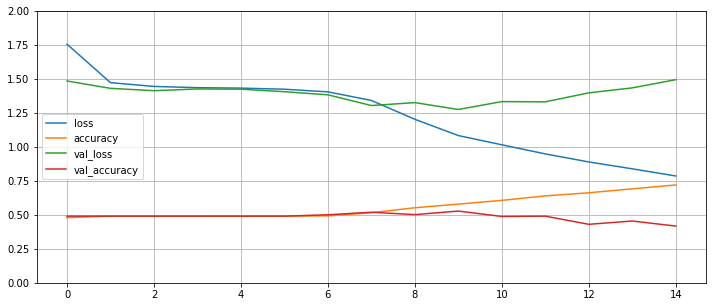

In [54]:
pd.DataFrame(history.history).plot(figsize=(12, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [55]:
loss, accuracy = model.evaluate(validation_padded, y_eval)

27/27 [==============================] - 1s 7ms/step - loss: 1.4587 - accuracy: 0.4271


In [56]:
print(f"Model accuracy is {accuracy * 100}%")

Model accuracy is 42.70711839199066%


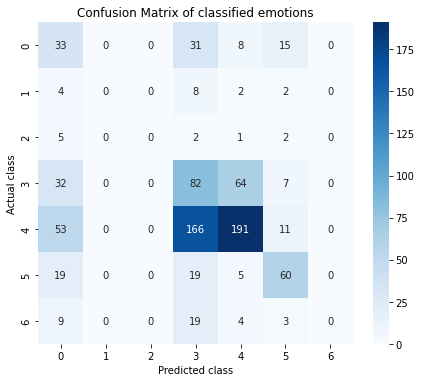

In [57]:
#cambiar el modelo para que funcione mediante el tokenizador correctamente
predicted_proba = np.argmax(model.predict(validation_padded), axis =-1)
confusion_matrix = tf.math.confusion_matrix(y_eval, predicted_proba).numpy()
figure = plt.figure(figsize = (6, 5))
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix of classified emotions")
plt.show()